# Data Download

In [1]:
# 캐글 설치
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [6]:
!gdown 1hBqTcWYEWdaydvRa7eSIOnEe-zu7RsZF
!unzip -q ham1000-segmentation-and-classification

Downloading...
From: https://drive.google.com/uc?id=1hBqTcWYEWdaydvRa7eSIOnEe-zu7RsZF
To: /content/ham1000-segmentation-and-classification.zip
100% 2.78G/2.78G [00:18<00:00, 154MB/s]


# Data Handling

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os 
import cv2
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score , recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Flatten, Dense 
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau

## Data Review

- 이미지 폴더안에 파일 개수 확인 - 10017개
- jpg형식의 이미지가 아닌 파일이 있는지 확인 - 텍스트파일 2개 존재
- 텍스트 파일 제거. 이미지는 총 10015장

In [8]:
# images 폴더안에 10017개 파일 존재
len(os.listdir('/content/images'))

10017

In [9]:
# 이미지 파일 확장자 확인
os.listdir('/content/images')[0][-3:]

'jpg'

In [10]:
# jpg 이미지가 아닌 파일들 찾기 -> 텍스트파일 2개 발견 및 삭제
for i in os.listdir('/content/images'):
  if i[-3:] != 'jpg':
    print(i)

ATTRIBUTION.txt
LICENSE.txt


In [11]:
!rm /content/images/ATTRIBUTION.txt
!rm /content/images/LICENSE.txt
len(os.listdir('/content/images'))

10015

In [12]:
# 이미지 경로 리스트 만들기

path = '/content/images/'
filenames = os.listdir(path)
image_path = []

for file in filenames:
  image_path.append(path + file)


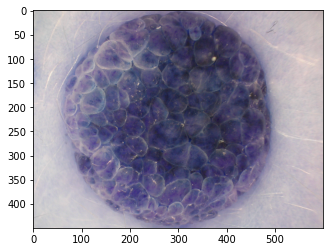

In [13]:
# 이미지 중 무작위로 뽑아서 시각화
random = np.random.randint(0,len(image_path))
img = cv2.imread(image_path[random])
plt.imshow(img)

In [14]:
# 이미지 사이즈 확인. (450, 600, 3) 이 아닌 다른 크기의 이미지가 있는지 검수.
for path in image_path:
  img = cv2.imread(path)
  # print(img.shape)
  if img.shape != (450, 600, 3):
    print(path)

## Label Matching

- 희소행렬 형태로 라벨이 들어있는 메타데이터의 파일을 이미지와 라벨 1대1로 매칭되도록 데이터프레임을 수정한다

In [15]:
# 파일 이름과 라벨 값이 들어있는 csv파일
gt_df = pd.read_csv('/content/GroundTruth.csv')
gt_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0


- 이미지 파일명과 라벨값이 들어있는 csv파일은 원-핫 인코딩처럼 7개의 라벨이 컬럼으로 있고 일치하는 라벨에는 1, 그외에는 0으로 표현되어있다
- 이대로 사용하기 불편하므로 파일명과 라벨 딕셔너리를 생성하고 데이터프레임의 image 컬럼을 for문 돌리면서 라벨 리스트를 생성, 데이터프레임에 label 컬럼으로 추가한다
- 컬럼에 image, label 두개만 남기면 파일명과 라벨 깔끔하게 나온다

In [17]:
image_label = {}

for i in range(len(gt_df)):
  info_dict = dict(gt_df.iloc[i])
  for key, value in info_dict.items():
    if value == 1.0:
      image_label[info_dict['image']] = key


# image_label

label_list = []

for img in gt_df['image']:
  label_list.append(image_label.get(img))

gt_df['label'] = label_list

gt_df

,image,MEL,NV,BCC,AKIEC,BKL,DF,VASC,label
0,ISIC_0024306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
1,ISIC_0024307,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
2,ISIC_0024308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
3,ISIC_0024309,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV
4,ISIC_0024310,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
...,...,...,...,...,...,...,...,...,...
10010,ISIC_0034316,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
10011,ISIC_0034317,1.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL
10012,ISIC_0034318,0.0,0.0,0.0,0.0,1.0,0.0,0.0,BKL
10013,ISIC_0034319,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NV


In [18]:
gt_df = gt_df[['image', 'label']]
gt_df

,image,label
0,ISIC_0024306,NV
1,ISIC_0024307,NV
2,ISIC_0024308,NV
3,ISIC_0024309,NV
4,ISIC_0024310,MEL
...,...,...
10010,ISIC_0034316,MEL
10011,ISIC_0034317,MEL
10012,ISIC_0034318,BKL
10013,ISIC_0034319,NV


- 문자 형태의 라벨들을 숫자로 변환하기 위해 사이킷런의 라벨 인코더 사용
- 사용법 : https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [20]:
labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
le = LabelEncoder()
le.fit(labels)
gt_df.label = le.transform(gt_df.label)
gt_df

<ipython-input-20-def2476d2a0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gt_df.label = le.transform(gt_df.label)


,image,label
0,ISIC_0024306,5
1,ISIC_0024307,5
2,ISIC_0024308,5
3,ISIC_0024309,5
4,ISIC_0024310,4
...,...,...
10010,ISIC_0034316,4
10011,ISIC_0034317,4
10012,ISIC_0034318,2
10013,ISIC_0034319,5


In [21]:
le.classes_

array(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'], dtype='<U5')

## Make Test dataset

- 전체 이미지 10015장에서 라벨당 10%씩 분할해서 998장의 테스트셋 생성.
- 훈련셋은 9017장

In [23]:
gt_df.value_counts().groupby('label').sum()

label
0     327
1     514
2    1099
3     115
4    1113
5    6705
6     142
dtype: int64

In [24]:
train_gt0 = gt_df[gt_df['label'] == 0].iloc[int(len(gt_df[gt_df['label'] == 0])*0.1):] # 295
train_gt1 = gt_df[gt_df['label'] == 1].iloc[int(len(gt_df[gt_df['label'] == 1])*0.1):] # 463
train_gt2 = gt_df[gt_df['label'] == 2].iloc[int(len(gt_df[gt_df['label'] == 2])*0.1):] # 990
train_gt3 = gt_df[gt_df['label'] == 3].iloc[int(len(gt_df[gt_df['label'] == 3])*0.1):] # 104
train_gt4 = gt_df[gt_df['label'] == 4].iloc[int(len(gt_df[gt_df['label'] == 4])*0.1):] # 1002
train_gt5 = gt_df[gt_df['label'] == 5].iloc[int(len(gt_df[gt_df['label'] == 5])*0.1):] # 6035
train_gt6 = gt_df[gt_df['label'] == 6].iloc[int(len(gt_df[gt_df['label'] == 6])*0.1):] # 128   = 9017

test_gt0 = gt_df[gt_df['label'] == 0].iloc[:int(len(gt_df[gt_df['label'] == 0])*0.1)] # 32
test_gt1 = gt_df[gt_df['label'] == 1].iloc[:int(len(gt_df[gt_df['label'] == 1])*0.1)] # 51
test_gt2 = gt_df[gt_df['label'] == 2].iloc[:int(len(gt_df[gt_df['label'] == 2])*0.1)] # 109
test_gt3 = gt_df[gt_df['label'] == 3].iloc[:int(len(gt_df[gt_df['label'] == 3])*0.1)] # 11
test_gt4 = gt_df[gt_df['label'] == 4].iloc[:int(len(gt_df[gt_df['label'] == 4])*0.1)] # 111
test_gt5 = gt_df[gt_df['label'] == 5].iloc[:int(len(gt_df[gt_df['label'] == 5])*0.1)] # 670
test_gt6 = gt_df[gt_df['label'] == 6].iloc[:int(len(gt_df[gt_df['label'] == 6])*0.1)] # 14

In [25]:
print(len(train_gt0), len(train_gt1), len(train_gt2), len(train_gt3), len(train_gt4), len(train_gt5), len(train_gt6))
print(len(test_gt0), len(test_gt1), len(test_gt2), len(test_gt3), len(test_gt4), len(test_gt5), len(test_gt6))

295 463 990 104 1002 6035 128
32 51 109 11 111 670 14


In [26]:
print(np.sum([295, 463, 990, 104, 1002, 6035, 128]) , np.sum([32, 51, 109, 11, 111, 670, 14]))
print(np.sum([295, 463, 990, 104, 1002, 6035, 128]) + np.sum([32, 51, 109, 11, 111, 670, 14]))

9017 998
10015


- 32+51+109+11+111+670+14 = 998
- 각 라벨당 10%씩 가져온 테스트셋은 총 998장
- 훈련셋은 총 9017장
- 다 합치면 10015장. 누락없이 ok.
- train_df, test_df로 concat

In [27]:
train_df = pd.concat([train_gt0, train_gt1, train_gt2, train_gt3, train_gt4, train_gt5, train_gt6])
train_df

,image,label
876,ISIC_0025182,0
890,ISIC_0025196,0
941,ISIC_0025247,0
958,ISIC_0025264,0
1013,ISIC_0025319,0
...,...,...
9538,ISIC_0033844,6
9663,ISIC_0033969,6
9685,ISIC_0033991,6
9890,ISIC_0034196,6


In [28]:
test_df = pd.concat([test_gt0, test_gt1, test_gt2, test_gt3, test_gt4, test_gt5, test_gt6])
test_df

,image,label
23,ISIC_0024329,0
66,ISIC_0024372,0
112,ISIC_0024418,0
144,ISIC_0024450,0
157,ISIC_0024463,0
...,...,...
598,ISIC_0024904,6
891,ISIC_0025197,6
938,ISIC_0025244,6
943,ISIC_0025249,6
